In [3]:
import numpy as np
import math

import struct
import os

from tqdm import tqdm

import snntorch as snn
import torch
import torch.nn as nn

import snntorch.spikeplot as splt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchmetrics.classification import MulticlassConfusionMatrix

from snntorch import surrogate
import snntorch.functional as SF
import torch.nn.functional as F
from torch.nn import NLLLoss, LogSoftmax

from snntorch import spikegen

from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import snntorch.spikeplot as splt
import imageio

from sklearn.metrics import ConfusionMatrixDisplay

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
import visualize
import dataset as ds

## Constants

In [ ]:
nCublets = 1000
nSensors = 100
max_t = 20
dt = 0.2
timesteps = int(max_t/dt)

In [ ]:
labels_map = {
  -1: "unclassified",
   0: "proton",
   1: "kaon",
   2: "pion",
   3: "other"
}
nClasses = len(labels_map)-1

# SNN Definition and Training

In [5]:
class Spiking_Net(nn.Module):
    """FCN with variable neural model and number of layers."""

    def __init__(self, net_desc, spikegen_fn):
        super().__init__()
        
        self.n_neurons = net_desc["layers"]
        self.timesteps = net_desc["timesteps"]
        self.output = net_desc["output"]

        modules = []
        for i_layer in range(1, len(self.n_neurons)):
            modules.append(nn.Linear(in_features=self.n_neurons[i_layer-1], out_features=self.n_neurons[i_layer]))
            if "model" in net_desc:
                modules.append(net_desc["model"](**net_desc["neuron_params"][i_layer]))
            else:
                modules.append(net_desc["neuron_params"][i_layer][0](**(net_desc["neuron_params"][i_layer][1])))
        self.network = nn.Sequential(*modules)

        self.spikegen_fn = spikegen_fn

    
    def forward(self, data):
        """Forward pass for several time steps."""

        x = self.spikegen_fn(data)

        # Initalize membrane potential
        mem = []
        for i, module in enumerate(self.network):
            if i%2==1:
                res = module.reset_mem()
                if type(res) is tuple:
                    mem.append(list(res))
                else:
                    mem.append([res])

        # Record the final layer
        spk_rec = []
        mem_rec = []

        # Loop over 
        spk = None
        for step in range(self.timesteps):
            for i_layer in range(len(self.network)//2):
                if i_layer == 0:
                    cur = self.network[2*i_layer](x[step])
                else:
                    cur = self.network[2*i_layer](spk)
                
                spk, *(mem[i_layer]) = self.network[2*i_layer+1](cur, *(mem[i_layer]))

                if i_layer == len(self.network)//2-1:
                    spk_rec.append(spk)
                    mem_rec.append(mem[i_layer][-1])

        if self.output == "spike":
            return torch.stack(spk_rec, dim=0)
        elif self.output == "membrane":
            return torch.stack(mem_rec, dim=0)

In [6]:
class Trainer():

    def __init__(self, net, loss_fn, optimizer,
                 train_dataset, val_dataset, test_dataset, predict=None):
        self.net = net
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.datasets = {"train": train_dataset, "validation": val_dataset, "test": test_dataset}
        self.predict = predict

        self.current_epoch = 0
        self.loss_hist = {"train": {}, "validation": {}, "test": {}}
        self.acc_hist = {"validation": {}, "test": {}}    


    def test(self, dataset_name, transform=None):

        # by default, computes accuracy on test dataset
        try:
            if dataset_name == "validation" or dataset_name == "test":
                dataset = self.datasets[dataset_name]
            else:
                raise NameError("Unidentified dataset name. Please choose between \"validation\" or \"test\".")
        except NameError as n:
            print(f"Error: {n}")

        temp_loss = []
        temp_acc = []

        self.net.eval()
        with torch.no_grad():
            temp_loss = []
            for data, targets in dataset:
                data = data.to(device)
                targets = targets.to(device)

                # forward pass
                output = self.net(data)
                pred, _ = self.predict(output, targets)

                # compute loss
                loss = self.loss_fn(pred, targets)
                temp_loss.append(loss.item())

                # calculate total accuracy
                if self.predict is not None:
                    pred, acc = self.predict(output, targets, transform)
                    temp_acc.append(acc)

        self.loss_hist[dataset_name][self.current_epoch] = np.mean(temp_loss)
        if self.predict is not None:
            self.acc_hist[dataset_name][self.current_epoch] = np.mean(temp_acc)


    def train(self, num_epochs, verbosity=1):

        self.net.to(device)

        # Validation
        self.test("validation")
        if verbosity:
            print(f"Epoch {self.current_epoch}:")
            print(f"Validation Loss = {self.loss_hist['validation'][self.current_epoch]}")
            if self.predict is not None:
                print(f"Validation Accuracy = {self.acc_hist['validation'][self.current_epoch]}")
            print("\n-------------------------------\n")

        for epoch in tqdm(range(num_epochs), desc="Epoch"):
            self.net.train()
            # Minibatch training loop
            for data, targets in tqdm(self.datasets["train"], desc="Batches", leave=False):
                data = data.to(device)
                targets = targets.to(device)

                # forward pass
                output = self.net(data)
                pred, _ = self.predict(output, targets)

                # compute loss
                loss_val = self.loss_fn(pred, targets)

                # Gradient calculation + weight update
                self.optimizer.zero_grad()
                loss_val.backward()
                self.optimizer.step()

                # Store loss history for future plotting
                if self.current_epoch in self.loss_hist["train"]:
                    self.loss_hist["train"][self.current_epoch].append(loss_val.item())
                else:
                    self.loss_hist["train"][self.current_epoch] = [loss_val.item()]

            self.current_epoch += 1

            # Validation
            self.test("validation")

            if verbosity:
                print(f"Epoch {self.current_epoch}:")
                print(f"Validation Loss = {self.loss_hist['validation'][self.current_epoch]}")
                if self.predict is not None:
                    print(f"Validation Accuracy = {self.acc_hist['validation'][self.current_epoch]}")
                print("\n-------------------------------\n")

    
    def plot_loss(self, validation=True, logscale=True):

        loss = [l for l_per_epoch in self.loss_hist["train"].values() for l in l_per_epoch]
        fig = plt.figure(facecolor="w", figsize=(10, 6))
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        if logscale:
            plt.yscale("log")
        plt.plot(loss, label="Training")
        if validation:
            x = [i*len(self.datasets["train"]) for i in self.loss_hist["validation"]]
            plt.plot(x, list(self.loss_hist["validation"].values()), color='orange', marker='o', linestyle='dashed', label="Validation")
        
        plt.legend(loc='upper right')
        plt.show()

    
    def ConfusionMatrix(self, *args, **kwargs):

        cm = MulticlassConfusionMatrix(*args, **kwargs)

        self.net.eval()
        with torch.no_grad():
            for data, targets in self.datasets["test"]:
                data = data.to(device)
                targets = targets.to(device)

                # forward pass
                output = self.net(data)

                # calculate total accuracy
                pred, acc = self.predict(output, targets)
                cm.update(pred, targets)
        
        return cm
    

    def plot_pred_vs_target(self, nbins, transform=None, logscale=False, *args, **kwargs):

        self.net.eval()
        all_targets = []
        all_predictions = []
        with torch.no_grad():
            for data, targets in self.datasets["test"]:
                data = data.to(device)
                targets = targets.to(device)

                # forward pass
                output = self.net(data)

                # calculate total accuracy
                pred, acc = self.predict(output, targets, transform)

                if transform:
                    targets = transform(targets)
                all_targets.extend(targets.tolist())
                all_predictions.extend(pred.tolist())

        fig = plt.figure(facecolor="w", figsize=(10, 6))
        plt.xlabel("Targets")
        plt.ylabel("Prediction")
        if logscale:
            plt.hist2d(all_targets, all_predictions, nbins, norm=SymLogNorm(*args, **kwargs), cmap='viridis')
        else:
            plt.hist2d(all_targets, all_predictions, nbins)

        # Add a color bar
        plt.colorbar(label='Counts')
        plt.plot([0, 1e5], [0, 1e5], color='white', linewidth=1, linestyle='--')


# Particle Classification

In [ ]:
data_train, data_test, data_val = ds.build_dataset("../Data", max_files=5, target="particle")

In [ ]:
batch_size = 50
nw = 0
train_load = DataLoader(data_train[:(len(data_train)//batch_size)*batch_size], batch_size=batch_size, shuffle=True, num_workers=nw)
val_load   = DataLoader(data_val[:(len(data_val)//batch_size)*batch_size],     batch_size=batch_size, shuffle=True, num_workers=nw)
test_load  = DataLoader(data_test[:(len(data_test)//batch_size)*batch_size],   batch_size=batch_size, shuffle=True, num_workers=nw)

In [ ]:
from collections import Counter
Counter([d[1] for d in data_train])

In [ ]:
#loss = nn.MSELoss()
num_inputs = 100
num_hidden = 200
num_outputs = nClasses
num_steps = timesteps
net = Net_LIF_1L(num_inputs, num_hidden, num_outputs, num_steps)

In [ ]:
def comp_accuracy(output, targets):
    _, predicted = output.sum(dim=0).max(1)
    total = targets.size(0)
    correct = (predicted == targets).sum().item()

    return predicted, correct/total

In [ ]:
loss_fn = SF.ce_count_loss(num_classes=nClasses)
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

train_net = Trainer(net, loss_fn, optimizer, train_load, val_load, test_load, comp_accuracy)

In [ ]:
num_epochs = 5
train_net.train(num_epochs)

In [ ]:
train_net.plot_loss()

In [ ]:
train_net.test("test", mc=True, num_classes=nClasses)
print(train_net.loss_hist["test"])
train_net.cm["test"].plot()

# Energy Regression

In [7]:
data_train, data_test, data_val = ds.build_dataset("../Data/PrimaryOnly", max_files=5, target="energy",
                                                   transform=lambda x: (x[0], ds.to_tensor_and_dtype(np.log10(x[1]), torch.float32)))

In [8]:
batch_size = 50
nw = 0
train_load = DataLoader(data_train[:(len(data_train)//batch_size)*batch_size], batch_size=batch_size, shuffle=True, num_workers=nw)
val_load   = DataLoader(data_val[:(len(data_val)//batch_size)*batch_size],     batch_size=batch_size, shuffle=True, num_workers=nw)
test_load  = DataLoader(data_test[:(len(data_test)//batch_size)*batch_size],   batch_size=batch_size, shuffle=True, num_workers=nw)

Minimum energy: 1.0979242324829102


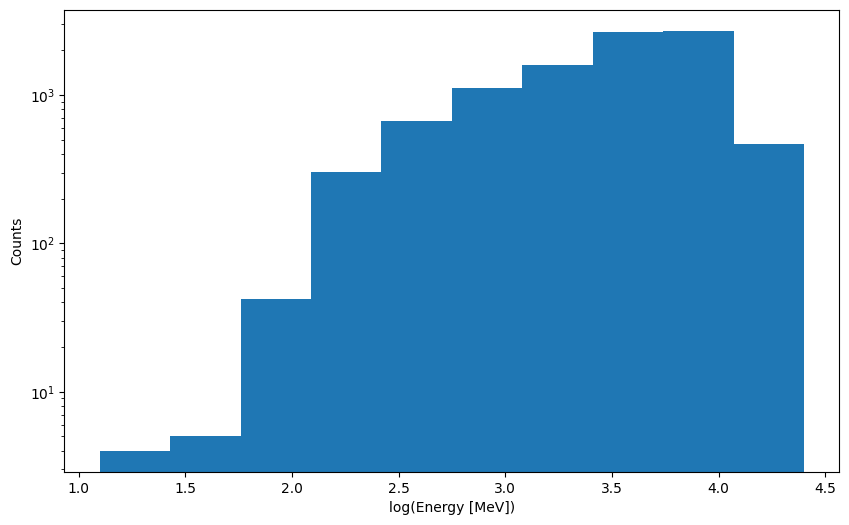

In [9]:
energies = ((np.array([d[1] for d in data_train])))

fig = plt.figure(facecolor="w", figsize=(10, 6))
plt.xlabel("log(Energy [MeV])")
plt.ylabel("Counts")
plt.yscale("log")
plt.hist(energies)

print(f"Minimum energy: {min(energies)}")

In [10]:
net_desc_regression = {
    "layers" : [100, 200, 1],
    "timesteps": 100,
    "output": "membrane",
    "neuron_params" : {
                1: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0,
                    "learn_threshold": True,
                    "spike_grad": surrogate.fast_sigmoid(),
                    }],
                2: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0e20,
                    "learn_threshold": False, 
                    "spike_grad": surrogate.fast_sigmoid(),
                    }]
                }
    }

def _spikegen(data):
    spike_data = data.transpose(0,1) 
    spike_train = torch.where(spike_data > 300, torch.tensor(1), torch.tensor(0)).to(torch.float32) 
    return spike_train


### Membrane Potential

In [13]:
net_desc_regression_multi = {
    "layers" : [400, 200, 1],
    "timesteps": 100,
    "output": "membrane",
    "neuron_params" : {
                1: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0,
                    "learn_threshold": True,
                    "spike_grad": surrogate.fast_sigmoid(),
                    }],
                2: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0e20,
                    "learn_threshold": False, 
                    "spike_grad": surrogate.fast_sigmoid(),
                    }]
                }
    }

def spikegen_multi(data, multiplicity=4):
    og_shape = data.shape
    spike_data = torch.zeros(og_shape[1], og_shape[0], multiplicity*og_shape[2])
    for i in range(multiplicity):
        condition = data > np.power(10, i+2)
        batch_idx, time_idx, sensor_idx = torch.nonzero(condition, as_tuple=True)
        spike_data[time_idx, batch_idx, multiplicity*sensor_idx+i] = 1

    return spike_data

def predict_from_mem(output, targets, transform=None):
    prediction = output[-1].squeeze(1)
    if transform:
        prediction, targets = transform(prediction), transform(targets)
    accuracy = torch.abs((targets - prediction)/targets)
    return prediction, torch.mean(accuracy)

net = Spiking_Net(net_desc_regression_multi, lambda x: spikegen_multi(x,4))

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_net = Trainer(net, loss_fn, optimizer, train_load, val_load, test_load, predict_from_mem)

In [ ]:
num_epochs = 5
train_net.train(num_epochs)

In [ ]:
train_net.test("test")
print(f"Test loss: {train_net.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_net.acc_hist['test'][num_epochs]*100}%")
train_net.plot_loss()
train_net.plot_pred_vs_target(50, logscale=False, linthresh=1)

In [ ]:
def antitransform(x):
    return torch.pow(10, x)

train_net.test("test", transform=antitransform)
print(f"Test loss: {train_net.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_net.acc_hist['test'][num_epochs]*100}%")
train_net.plot_pred_vs_target(50, transform=antitransform, logscale=True, linthresh=1)

### SpikeFreq

In [14]:
population = 10
net_desc_spikefreq = {
    "layers" : [400, 200, population],
    "timesteps": 100,
    "output": "membrane",
    "neuron_params" : {
                1: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0,
                    "learn_threshold": True,
                    "spike_grad": surrogate.fast_sigmoid(),
                    }],
                2: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0,
                    "learn_threshold": True, 
                    "spike_grad": surrogate.fast_sigmoid(),
                    }]
                }
    }

def predict_spikefreq(output, targets, transform=None):
    prediction = output.sum((0,2))/(output.shape[0]*output.shape[2])
    if transform:
        prediction, targets = transform(prediction), transform(targets)
    accuracy = torch.abs((targets - prediction)/targets)
    return prediction, torch.mean(accuracy)

net = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4))

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_net = Trainer(net, loss_fn, optimizer, train_load, val_load, test_load, predict_spikefreq)

In [15]:
num_epochs=10
train_net.train(num_epochs)

Epoch 0:
Validation Loss = 21.711168492094
Validation Accuracy = 1.34739089012146

-------------------------------



Epoch:  10%|█         | 1/10 [00:32<04:55, 32.80s/it]

Epoch 1:
Validation Loss = 0.4694348874878376
Validation Accuracy = 0.16262514889240265

-------------------------------



Epoch:  20%|██        | 2/10 [01:05<04:19, 32.46s/it]

Epoch 2:
Validation Loss = 0.2454162728279195
Validation Accuracy = 0.1110396683216095

-------------------------------



Epoch:  30%|███       | 3/10 [01:37<03:47, 32.50s/it]

Epoch 3:
Validation Loss = 0.16347527773456372
Validation Accuracy = 0.0907270684838295

-------------------------------



Epoch:  40%|████      | 4/10 [02:10<03:15, 32.66s/it]

Epoch 4:
Validation Loss = 0.06188581907685767
Validation Accuracy = 0.057489216327667236

-------------------------------



Epoch:  50%|█████     | 5/10 [02:43<02:44, 32.80s/it]

Epoch 5:
Validation Loss = 0.035906889892004905
Validation Accuracy = 0.04363420233130455

-------------------------------



Epoch:  60%|██████    | 6/10 [03:15<02:10, 32.67s/it]

Epoch 6:
Validation Loss = 0.03014356718259923
Validation Accuracy = 0.04101857542991638

-------------------------------



Epoch:  70%|███████   | 7/10 [03:48<01:37, 32.66s/it]

Epoch 7:
Validation Loss = 0.024725843993748758
Validation Accuracy = 0.035548701882362366

-------------------------------



Epoch:  80%|████████  | 8/10 [04:21<01:05, 32.68s/it]

Epoch 8:
Validation Loss = 0.01737740287121306
Validation Accuracy = 0.03013799712061882

-------------------------------



Epoch:  90%|█████████ | 9/10 [04:53<00:32, 32.51s/it]

Epoch 9:
Validation Loss = 0.01679054374231937
Validation Accuracy = 0.029451273381710052

-------------------------------



Epoch: 100%|██████████| 10/10 [05:25<00:00, 32.56s/it]

Epoch 10:
Validation Loss = 0.029534212927869025
Validation Accuracy = 0.03916223347187042

-------------------------------



Test loss: 0.03032132238149643
Test relative error: 3.9478354454040527%


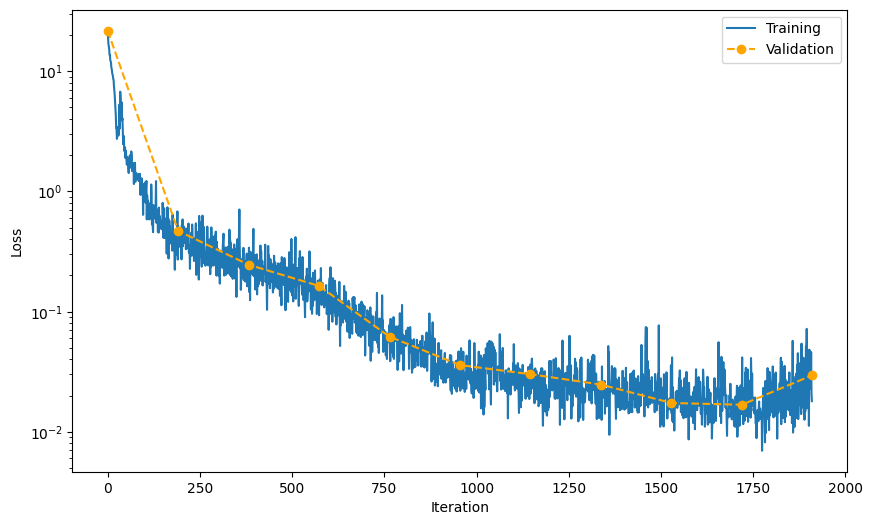

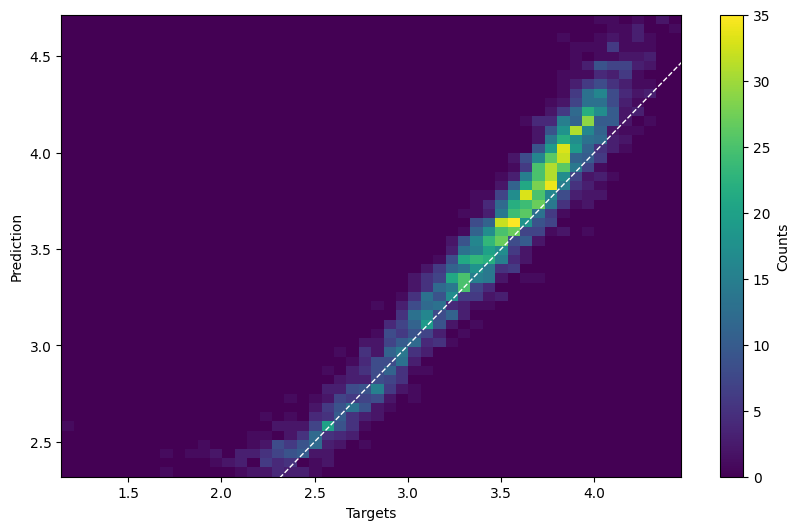

In [16]:
train_net.test("test")
print(f"Test loss: {train_net.loss_hist['test'][10]}")
print(f"Test relative error: {train_net.acc_hist['test'][10]*100}%")
train_net.plot_loss()
train_net.plot_pred_vs_target(50, logscale=False, linthresh=1)

Test loss: 0.030321322634058484
Test relative error: 41.10873031616211%


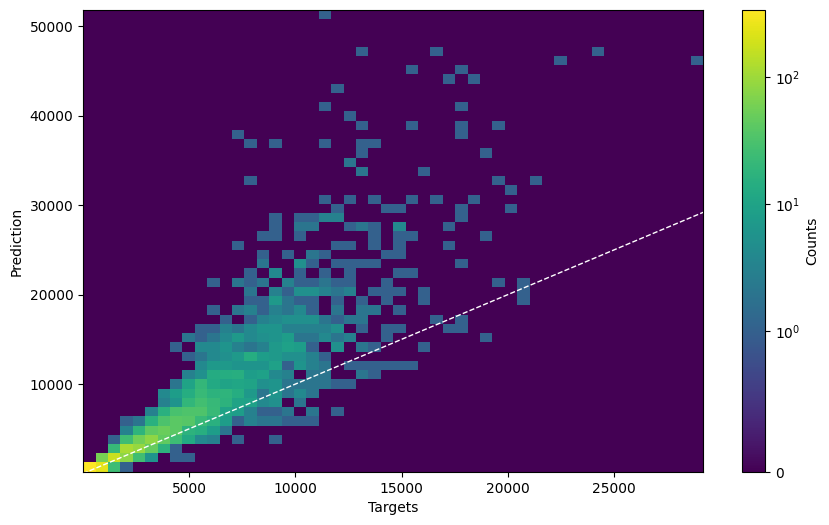

In [18]:
def antitransform(x):
    return torch.pow(10, x)

train_net.test("test", transform=antitransform)
print(f"Test loss: {train_net.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_net.acc_hist['test'][num_epochs]*100}%")
train_net.plot_pred_vs_target(50, transform=antitransform, logscale=True, linthresh=1)

In [60]:
lin_model = LinearRegression()
x, y = zip(*[data_train[i] for i in range(len(data_train))])

# Convert to NumPy arrays
x = torch.stack(x).sum((1,2)).numpy().reshape(-1,1)  # Convert features to NumPy
y = np.pow(10, torch.stack(y).numpy().ravel()) 
lin_model.fit(x, y)

print("Slope:", lin_model.coef_[0])
print("Intercept:", lin_model.intercept_)

Slope: 0.001209248
Intercept: 1578.1741


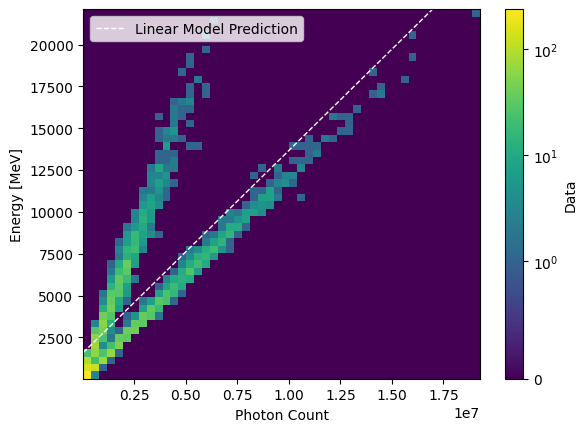

In [111]:
x_test, y_test = zip(*[data_train[i] for i in range(len(data_test))])

# Convert to NumPy arrays
x_test = torch.stack(x_test).sum((1,2)).numpy().reshape(-1,1)  # Convert features to NumPy
y_test = np.pow(10, torch.stack(y_test).numpy().ravel())

plt.xlabel("Photon Count")
plt.ylabel("Energy [MeV]")
plt.hist2d(x_test.reshape(-1), y_test, 50, norm=SymLogNorm(linthresh=1), cmap='viridis')
plt.colorbar(label='Data')
x_plot = np.arange(0, np.max(x), 1e3)
y_plot = lin_model.predict(x_plot.reshape(-1,1))
plt.plot(x_plot, y_plot, color='white',
         linewidth=1, linestyle='--', label="Linear Model Prediction")
plt.legend()

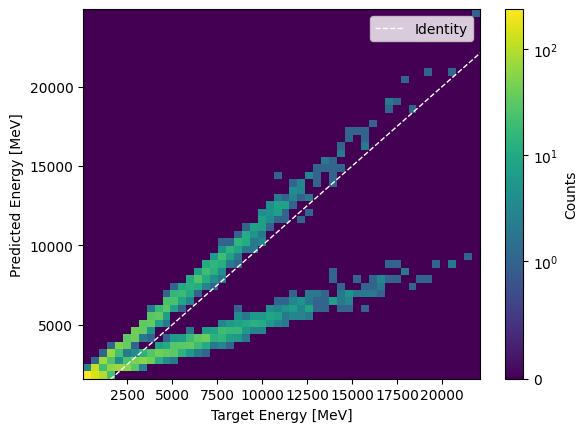

In [117]:
y_pred = lin_model.predict(x_test)

plt.xlabel("Target Energy [MeV]")
plt.ylabel("Predicted Energy [MeV]")
plt.hist2d(y_test, y_pred, 50, norm=SymLogNorm(linthresh=1), cmap='viridis')
plt.colorbar(label='Counts')
plt.plot([0, 1e5], [0, 1e5], color='white', linewidth=1, linestyle='--', label="Identity")
plt.legend(loc='best')

In [121]:
acc = np.mean(abs((y_test-y_pred)/y_test)*100)
print(f"Mean relative error: {acc}%")

Mean relative error: 104.2289047241211%


# Energy Dispersion

In [ ]:
data_train, data_test, data_val = ds.build_dataset("../Data/PrimaryOnly", max_files=5, target="dispersion",
                                                   transform= lambda x: (x[0], ds.to_tensor_and_dtype(x[1], torch.float32)))

In [ ]:
batch_size = 50
nw = 0
train_load = DataLoader(data_train[:(len(data_train)//batch_size)*batch_size], batch_size=batch_size, shuffle=True, num_workers=nw)
val_load   = DataLoader(data_val[:(len(data_val)//batch_size)*batch_size],     batch_size=batch_size, shuffle=True, num_workers=nw)
test_load  = DataLoader(data_test[:(len(data_test)//batch_size)*batch_size],   batch_size=batch_size, shuffle=True, num_workers=nw)

In [ ]:
sigmaE = ((np.array([d[1] for d in data_train])))

fig = plt.figure(facecolor="w", figsize=(10, 6))
plt.xlabel(r'$\sigma_{E}$', fontsize=14)
plt.ylabel("Counts")
plt.yscale("log")
plt.hist(sigmaE)

#print(f"Minimum energy: {min(energies)}")

In [ ]:
population = 10
net_desc_spikefreq = {
    "layers" : [400, 200, population],
    "timesteps": 100,
    "output": "membrane",
    "neuron_params" : {
                1: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0,
                    "learn_threshold": True,
                    "spike_grad": surrogate.fast_sigmoid(),
                    }],
                2: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0,
                    "learn_threshold": True, 
                    "spike_grad": surrogate.fast_sigmoid(),
                    }]
                }
    }

def predict_spikefreq(output, targets, population=10):
    prediction = output.sum((0,2))/(output.shape[0]*output.shape[2])
    accuracy = torch.abs((targets - prediction)/targets)
    return prediction, torch.mean(accuracy)

net = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4))

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_net = Trainer(net, loss_fn, optimizer, train_load, val_load, test_load, predict_spikefreq)

In [ ]:
num_epochs=6
train_net.train(num_epochs)

In [ ]:
train_net.test("test")
print(f"Test loss: {train_net.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_net.acc_hist['test'][num_epochs]*100}%")
train_net.plot_loss()
train_net.plot_pred_vs_target(50, logscale=False, linthresh=1)


# N of interactions

In [ ]:
data_train, data_test, data_val = ds.build_dataset("../Data/PrimaryOnly", max_files=5, target="N_int",
                                                   transform= lambda x: (x[0], ds.to_tensor_and_dtype(x[1], torch.float32)))

In [ ]:
batch_size = 50
nw = 0
train_load = DataLoader(data_train[:(len(data_train)//batch_size)*batch_size], batch_size=batch_size, shuffle=True, num_workers=nw)
val_load   = DataLoader(data_val[:(len(data_val)//batch_size)*batch_size],     batch_size=batch_size, shuffle=True, num_workers=nw)
test_load  = DataLoader(data_test[:(len(data_test)//batch_size)*batch_size],   batch_size=batch_size, shuffle=True, num_workers=nw)

In [ ]:
Nint = ((np.array([d[1] for d in data_train])))

fig = plt.figure(facecolor="w", figsize=(10, 6))
plt.xlabel(r'$\sigma_{E}$', fontsize=14)
plt.ylabel("Counts")
plt.yscale("log")
plt.hist(Nint)


In [ ]:
min(Nint)

In [ ]:
idx = 15
print(Nint[idx])
visualize.plot_views(idx, data_train)

# OLD

In [ ]:
class Net_LIF_1L(nn.Module):
    """FCN with 1 hidden layer and LIF neurons."""

    def __init__(self, input_feat, hidden, out_feat, timesteps,
                 learnable=True, beta=0.8, threshold=1.0):
        super().__init__()
        
        self.input_feat = input_feat          # number of input neurons 
        self.hidden = hidden                  # number of hidden neurons
        self.out_feat = out_feat              # number of output neurons
        
        self.timesteps = timesteps            # number of time steps to simulate the network

        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold,
                                learn_beta=learnable, learn_threshold=learnable)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold,
                                 learn_beta=learnable, learn_threshold=learnable)
        
    def _spikegen(self, data):
        spike_data = data.transpose(0,1) 
        spike_train = torch.where(spike_data > 300, torch.tensor(1), torch.tensor(0)).to(torch.float32) 
        return spike_train
    
    def forward(self, data):
        """Forward pass for several time steps."""

        x = self._spikegen(data)

        # Initalize membrane potential
        mem1 = self.lif_in.init_leaky()
        mem2 = self.lif_out.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
                
            cur1 = self.fc_in(x[step])
            spk1, mem1 = self.lif_in(cur1, mem1)
            cur2 = self.fc_out(spk1)
            spk2, mem2 = self.lif_out(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0)

In [ ]:
class Net_Reg(nn.Module):
    """FCN with 1 hidden layer and LIF neurons."""

    def __init__(self, input_feat, hidden, timesteps,
                 learnable=True, beta=0.8, threshold=1.0):
        super().__init__()
        
        self.input_feat = input_feat          # number of input neurons 
        self.hidden = hidden                  # number of hidden neurons
        self.out_feat = 1                     # number of output neurons
        
        self.timesteps = timesteps            # number of time steps to simulate the network

        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold,
                                learn_beta=learnable, learn_threshold=learnable)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=1e20,
                                 learn_beta=learnable)
        
    def _spikegen(self, data):
        spike_data = data.transpose(0,1) 
        spike_train = torch.where(spike_data > 300, torch.tensor(1), torch.tensor(0)).to(torch.float32) 
        return spike_train
    
    def forward(self, data):
        """Forward pass for several time steps."""

        x = self._spikegen(data)

        # Initalize membrane potential
        mem1 = self.lif_in.init_leaky()
        mem2 = self.lif_out.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
                
            cur1 = self.fc_in(x[step])
            spk1, mem1 = self.lif_in(cur1, mem1)
            cur2 = self.fc_out(spk1)
            spk2, mem2 = self.lif_out(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return  mem2_rec[-1].squeeze(1)

In [ ]:
#loss = nn.MSELoss()
num_inputs = 100
num_hidden = 200
num_steps = timesteps
net2 = Net_Reg(num_inputs, num_hidden, num_steps)

In [ ]:
def accuracy_set(net, data_loader, loss_fn, comp_mc=False):
    mcm = MulticlassConfusionMatrix(num_classes=nClasses, normalize='none')
    net.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        temp_loss = []
        for data, targets in data_loader:
            data = data.to(device)
            targets = targets.to(device)

            # create spike train
            spike_in = custom_spikegen(data)
            spike_in = spike_in.to(device)

            # forward pass
            output = net(spike_in)

            # compute loss
            loss = loss_fn(output, targets)
            temp_loss.append(loss.item())

            # calculate total accuracy
            tot, corr, pred = comp_accuracy(output, targets)
            total += tot
            correct += corr
            if comp_mc:
                mcm.update(pred, targets)

        mean_loss = np.mean(temp_loss)
        acc = correct/total

        return mean_loss, acc, mcm

In [ ]:
def train_net(net, train_loader, val_loader, num_epochs, loss_fn, optimizer, batch_size=100):

    net.to(device)
    
    loss_hist = []
    loss_val_hist = []
    acc_val_hist = []

    iter_counter = 0

    # Validation
    mean_loss_val, acc_val, _ = accuracy_set(net, val_loader, loss_fn, batch_size)

    loss_val_hist.append(mean_loss_val)
    acc_val_hist.append(acc_val)
    print(f"Validation Set Loss: {mean_loss_val}")
    print(f"Validation Set Accuracy: {100 *acc_val:.2f}%")
    print("\n--------------------------------------------------\n")

    for epoch in range(num_epochs):
        net.train()
        batch_counter = 0
        # Minibatch training loop
        for data, targets in train_loader:
            data = data.to(device)
            targets = targets.to(device)

            # create spike train
            spike_in = custom_spikegen(data)
            spike_in = spike_in.to(device)

            # forward pass
            output = net(spike_in)

            # compute loss
            loss_val = loss_fn(output, targets)
        
            # Gradient calculation + weight update
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            # Store loss history for future plotting
            loss_hist.append(loss_val.item())
        
            if iter_counter % 50 == 0:
                print("Epoch:", epoch+1)
                print("Batch:", batch_counter)
                print("Iteration:", iter_counter)
                print("Loss:", loss_val.item(),"\n")
        
            batch_counter += 1
            iter_counter += 1

        # Validation
        mean_loss_val, acc_val, _ = accuracy_set(net, val_loader, loss_fn, batch_size)

        loss_val_hist.append(mean_loss_val)
        acc_val_hist.append(acc_val)
        print(f"Validation Set Loss: {mean_loss_val}")
        print(f"Validation Set Accuracy: {100 *acc_val:.2f}%")
        print("\n--------------------------------------------------\n")

    return loss_hist, loss_val_hist, acc_val_hist

In [ ]:
net = Net_LIF_1L(num_inputs, num_hidden, num_outputs, num_steps).to(device)
net.train()

In [ ]:
num_epochs = 5
iter_counter = 0

#loss = nn.MSELoss()
num_inputs = 100
num_hidden = 200
num_outputs = nClasses
num_steps = timesteps
net = Net_LIF_1L(num_inputs, num_hidden, num_outputs, num_steps).to(device)
loss_fn = SF.ce_count_loss(num_classes=nClasses)
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

res = train_net(net, train_load, val_load, num_epochs, loss_fn, optimizer, batch_size=100)

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(res[0])
plt.title("Train loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
#plt.yscale("log")
plt.show()

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(res[1])
plt.title("Validation loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
#plt.yscale("log")
plt.show()

In [ ]:
test = accuracy_set(net, test_load, loss_fn, True)
test[2].plot()

In [ ]:

for data, targets in train_load:
            data = data.to(device)
            targets = targets.to(device)

            # create spike train
            spike_in = custom_spikegen(data)
            spike_in = spike_in.to(device)

            print(spike_in.shape)
            break